In [154]:
using Statistics, DifferentialEquations, ColorSchemes
using CairoMakie, HDF5, Colors, StatsFuns, FileIO, Makie.GeometryBasics
include("../SocialEconomicDiversity/core.jl");

In [197]:
#function to compute lorenz curve for income/wealth distribution
function lorenz(v)  # assumed sorted vector
    S = cumsum(v)  # cumulative sums: [v[1], v[1] + v[2], ... ]
    F = (1:length(v)) / length(v)
    L = S ./ S[end]
    return (; F, L) # returns named tuple
end

lorenz (generic function with 1 method)

# The model is:

## Original dimensional model


 $\dot{x}  =  rx(1-x/K)  -  x\sum_{i=1}^N q_ie_i   $
 
   $\dot{e_i}  =  \alpha_i(pq_ix - w_i) $
   
  $\textrm{s.t.}  \quad 0 \leq e_i \leq \bar{e}_i $
  

## Non-dimensionalized model


 $ \dot{y} = y(1-y)  -  y\sum_{i=1}^N u_i $
 
 $ \dot{u_i}  = \tilde{\alpha}_i(y-\tilde{w}_i) $
 
 $\textrm{s.t.}  \quad 0 \leq u_i \leq \bar{u}_i $
 
 
 Where


$ y=x/K, \hspace{5mm} u_i = q_i e_i / r, \hspace{5mm} \tilde{\alpha}_i =\frac{\alpha_i p K   q_i ^2}{r^2}, \hspace{5mm} \tilde{w}_i = \frac{w_i}{q_i p K}, \hspace{5mm}  \bar{u}_i  = \frac{\bar{e}_i  q_i }{r} \label{eq:nond_params}
$

Revnue calculations:

define the 'opportunity cost' $w_i$ as the cost of harvesting, $c_i$ plus the cost of lost wages from outside, $w_{io}$. That is, $w_i = c_i + w_{io}$. Then in the dimensional case, 

$R_{ih} =  e_i(p q_i  x - c_i)$ 

$R_{io} = (\bar{e}_i - e_i) w_{io}$ 

$R = R_{ih} + R_{io} =  p q_i e_i x - c_i e_i + (\bar{e}_i - e_i) w_{io}$ 

So far, we have simply been lumping $c_i$ and $w_{io}$, but now that we want to interpret the results in the dimensional space, we need to take care. So, given our defintion of $\tilde{w}_i$, we have equivalent $\tilde{w}_{io}$ and $\tilde{c}_i$.  After some algebra, the non-dimensional harvesting revenue is 

$\tilde{R}_{ih} = u_i(y - \tilde{c}_i)$

$\tilde{R}_{io} = (\bar{u}_i - u_i) \tilde{w}_{io}$

where $\tilde{R}_{ih} = \frac{R_{ih}}{rpK}$ and $\tilde{R}_{io} = \frac{R_{io}}{rpK}$.

That is, we can immediately convert between dimensionless and dimensional revenue using the conversion facter $rpK$. The coolest thing about this is that $rpK$ is simply a 'system scale' parameter.  It is otherwise meaningless for the the dynamics of the system!  It just tells us what the scale of the wages and costs must be for anything to happen in the system.  

You will see that our analysis so far has assumed the real costs of fishing are zero.  This does not affect our general results, i.e. we can WLOG make this assumption. But if we want details of distributions, we need to consider it. 

Finally, if we want to see the 'resource rent' or 'economic profit' as opposed to 'accounting profit' shown above, then that is given by

$R_{ihr} =  e_i(p q_i  x - c_i - w_{io})$ 

$\tilde{R}_{ihr} = u_i(y - \tilde{c}_i  -\tilde{w}_{io}) = u_i(y -\tilde{w}_{i})$



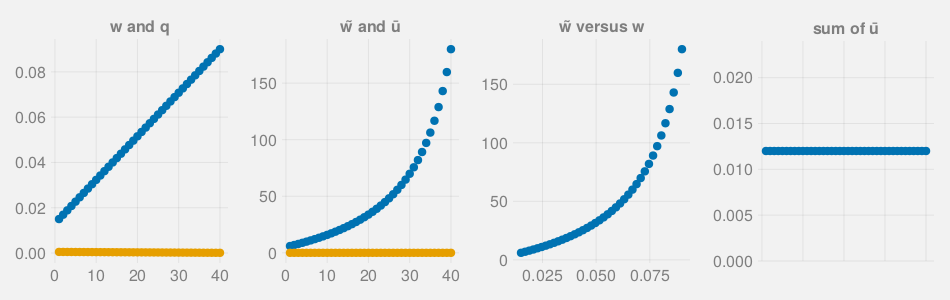

In [238]:
N=40
r=1;K=1;p=5;ē=1
q=0.01 .* range(0.05,0.01,N);
c=range(0.00,0.00,N);
wₒ=1.5 .* range(0.01,0.06,N);
w = c .+ wₒ;
c̃=c./(q.*p.*K);
w̃ₒ=wₒ./(q.*p.*K);
w̃=c̃ .+ w̃ₒ;
ū=ē.*q./r;


#plot separately
f=Figure(backgroundcolor = :grey95, resolution = (950, 300))
a1=Axis(f[1,1];title="w and q")
scatter!(a1,w)
scatter!(a1,q)

a2=Axis(f[1,2];title="w̃ and ū")
scatter!(a2,w̃)
scatter!(a2,ū)

a3=Axis(f[1,3];title="w̃ versus w")
scatter!(a3,w,w̃)


a4=Axis(f[1,4];title="sum of ū",aspect=0.8, xticklabelsvisible= false)
scatter!(a4,range(sum(ū),sum(ū),N))
    

f

resource level:1.0


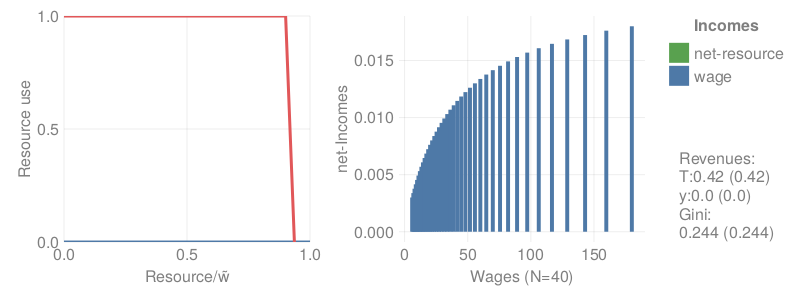

In [239]:
vis(scenario(institution="OA";N,w̃,ū),show_individual_u=false,xlim=(0,5))

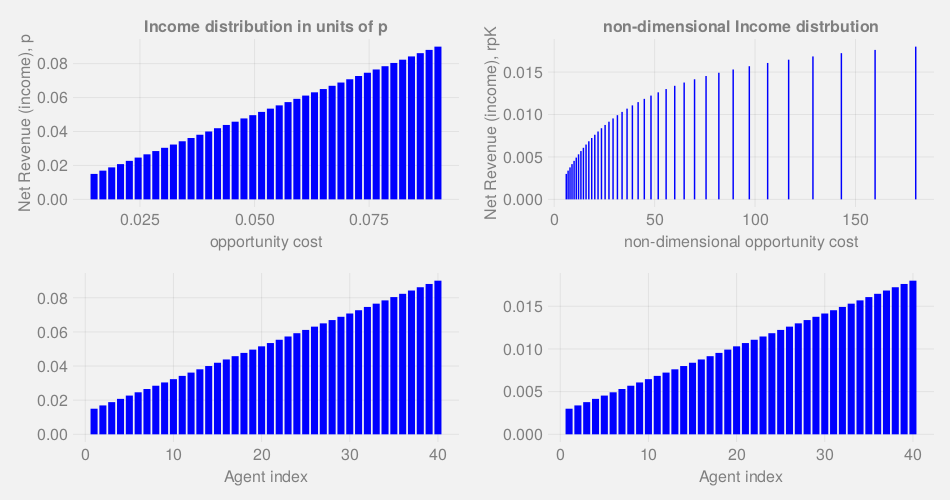

In [240]:
s=sim(scenario(institution="OA";N,w̃,ū));

#non-dimensional revenues

R̃ₒ = (ū .- s.final.u) .* w̃ₒ; 
R̃ₕ = s.final.u.*(s.final.y .- c̃);
R̃ₕᵣ= s.final.u.*(s.final.y .- w̃);
R̃ = R̃ₒ .+  R̃ₕ;

#dimensional revenues

Rₒ = r*p*K*R̃ₒ
Rₕ = r*p*K*R̃ₕ
Rₕᵣ = r*p*K*R̃ₕᵣ
R = r*p*K*R̃


fig2=Figure(backgroundcolor = :grey95, resolution = (950, 500))
ax1 = Axis(fig2[1, 1], title = "Income distribution in units of p", ylabel = "Net Revenue (income), p",
    xlabel="opportunity cost")
ax2 = Axis(fig2[1, 2], title = "non-dimensional Income distrbution", ylabel = "Net Revenue (income), rpK",
    xlabel = "non-dimensional opportunity cost")
ax3 = Axis(fig2[2, 1],xlabel="Agent index")
ax4 = Axis(fig2[2, 2],xlabel = "Agent index")
barplot!(ax1,w,R,color=:blue)
barplot!(ax1,w,Rₕ,color=:green)
barplot!(ax1,w,Rₕᵣ,color=:red)
barplot!(ax2,w̃,R̃,color=:blue)
barplot!(ax2,w̃,R̃ₕ,color=:green)
barplot!(ax2,w̃,R̃ₕᵣ,color=:red)
barplot!(ax3,R,color=:blue)
barplot!(ax3,Rₕ,color=:green)
barplot!(ax3,Rₕᵣ,color=:red)
barplot!(ax4,R̃,color=:blue)
barplot!(ax4,R̃ₕ,color=:green)
barplot!(ax4,R̃ₕᵣ,color=:red)
fig2

In [241]:
#vis(sim(scenario(institution="OA";N,w̃,ū),tend=(0.0,5000)),show_individual_u=true)

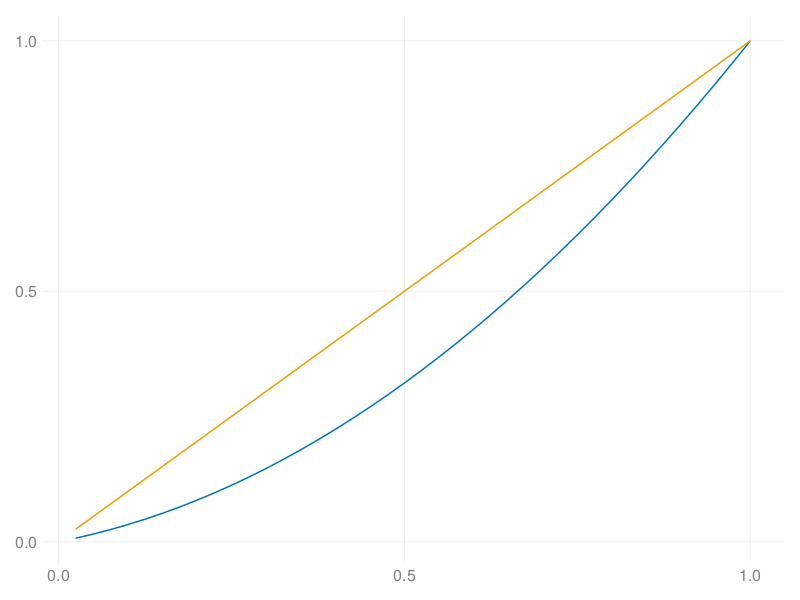

In [242]:
F,L=lorenz(sort(R̃))
figure=lines(F, L, label = "Lorenz curve, lognormal sample")
lines!(F, F, label = "Lorenz curve, equality")
figure

Case below, effort restricted, everyone in fishery, max system revenue = 0.25 (MSY)

resource level:0.5


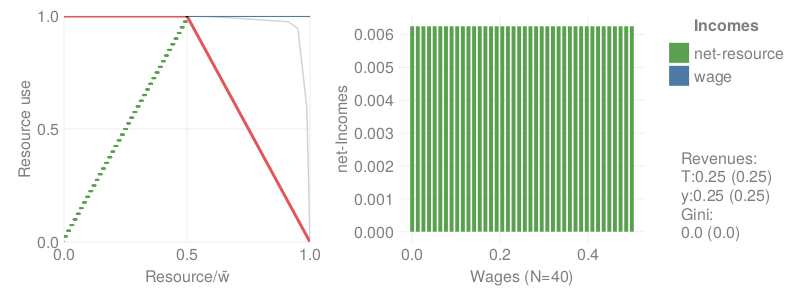

In [183]:
vis(scenario(institution="OA",w̃_mean=0.25,N=40, ū_sum=0.5),show_individual_u=false,xlim=(0,5))

Next is the case with no diversity. Case = equal. Effort consrained. As long as wages are less than 0.5. Everyone is in fishery. If there are wage opportunities, total income goes up. Contribution of resource goes down. 

resource level:0.7


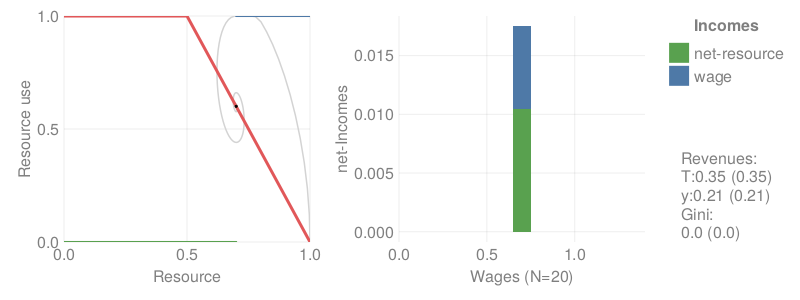

In [4]:
vis(scenario(institution="OA",w̃_mean=0.7,ū_sum=0.5,case="equal",N=20))

### case=average means that the range is 0.5

resource level:0.372


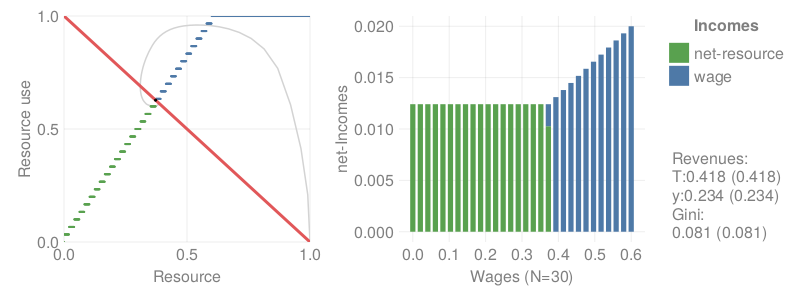

In [5]:
vis(scenario(institution="OA",w̃_mean=0.3,ū_sum=1,w̃_spread=0.1,N=30))

resource level:0.545


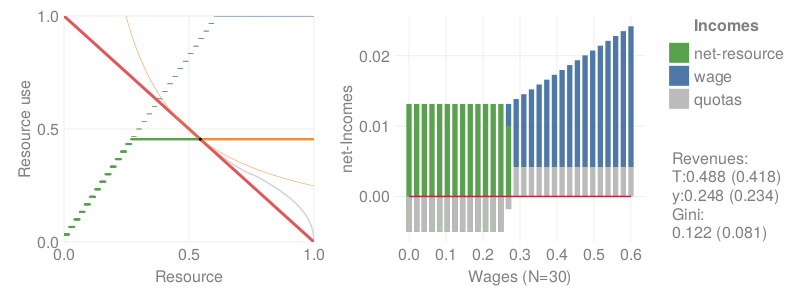

In [6]:
vis(scenario(institution="TQ",w̃_mean=0.3,ū_sum=1,w̃_spread=0.1,N=30,target=0.248))

resource level:0.545


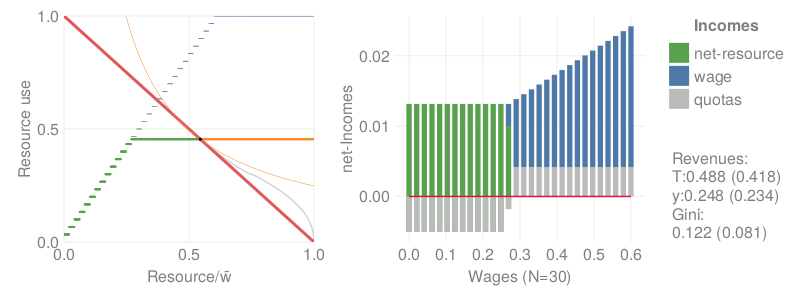

In [79]:
vis(scenario(institution="TQ",w̃_mean=0.3,ū_sum=1,w̃_spread=0.1,N=30,target=0.248))

resource level:0.55


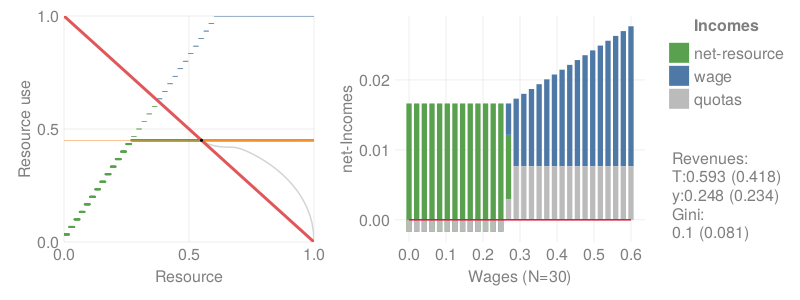

In [8]:
vis(scenario(institution="TQu",w̃_mean=0.3,ū_sum=1,w̃_spread=0.1,N=30,target=0.45))